# Training & Prediction fallow active agricultural areas
The goal of the script is to make use of sklearns algorithms for Random Forest and Support Vector Machine classifiers to train and predict fallow and active agricultural areas across Europe

Steps
- Import ROI 
- Load Sampling Data containing STM's and other info
- train-test splitting
- model training
- prediction
- accuracy assesment
- Output visualization

In [1]:
from osgeo import ogr, osr, gdal
import geemap, ee
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import math
from scipy.stats import norm, gamma, f, chi2
from functools import partial
import concurrent.futures
import pickle
import logging
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import joblib
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
import folium
import sys
import os

In [2]:
#workPath = 'D:/OneDrive - Humboldt-Universitaet zu Berlin, CMS/uni/WS_23_24/Geopy/MAP_git'
#workPath = "/Users/rubenbutzer/Library/CloudStorage/OneDrive-Humboldt-UniversitaetzuBerlin,CMS/uni/WS_23_24/Geopy/MAP_git"
#workPath = r'\\141.20.141.12\SAN_BioGeo\_HiWi\Ruben\wildE'
workPath = 'E:/MAP_git'

In [3]:
sys.path.append(workPath)
from tools import *
from tools_schnesha import *
from tools_butzerru import *

In [4]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Einladen der Sampling Daten

- hier kann schon gewählt werden, welche Seasons eingeladen werden sollen.

- weiterhin kann mit max_subset_size stattdessen ein subset geladen werden für schnelleres Prozessieren. Dafür muss if True gesetzt sein. 

In [5]:
# Definiere eine Liste von Seasons, die du verwenden möchtest
desired_seasons = ['3-9']

# Konvertiere die gewünschten Jahreszeiten in einen lesbaren String
seasons_str = '_'.join(desired_seasons)

# Optional: Definiere die maximale Größe des zwischengespeicherten Subsets
max_subset_size = 'all'
#max_subset_size = 100000

# Definiere den Pfad zur LUCAS-Beispieldatei im CSV-Format
path = os.path.join(workPath, '01_Sampling', 'lucas_points', 'LUCAS_sample_Both_Classes_All.csv')

#sampling_data = pd.read_csv(path)


# Überprüfe, ob das Pickle bereits vorhanden ist
pickle_file_name = f"LUCAS_random_sample_{seasons_str}"
if max_subset_size != 'all':
    if max_subset_size > 1774881:
        print("Die gewünschte Sample-Größe ist größer als die verfügbaren Daten. Bitte 'all' bei desired_seasons eingeben.")
        desired_seasons = 'all'
    else:
        pickle_file_name += f"_{max_subset_size}"
pickle_file_name += ".pkl"
pickle_path = os.path.join(workPath, "02_Training", "train_pickle", pickle_file_name)

if os.path.exists(pickle_path):
    print(f"Loading data from pickle {pickle_path}...")
    # Lade das Pickle direkt, wenn vorhanden
    training_data = pd.read_pickle(pickle_path)

    # Entferne Duplikate und fehlende Werte aus den Trainingsdaten
    training_data = training_data.drop_duplicates().dropna()

    # Ersetze den Wert "agriculture" in der Spalte 'land_use_classes' durch "active"
    training_data['land_use_classes'] = training_data['land_use_classes'].replace('agriculture', 'active')
else:
    print("Pickle file not found. Generating training data...")
    # Lade die CSV-Datei als Pandas DataFrame
    sampling_data = pd.read_csv(path)

    # Initialisiere eine leere DataFrame, um die gefilterten Daten zu speichern
    training_data = pd.DataFrame()

    # Iteriere über jede Season und filtere die Daten entsprechend
    for season in desired_seasons:
        # Filtere die Daten für die aktuelle Season
        season_data = sampling_data[sampling_data['season'] == season]

        # Füge die gefilterten Daten zur DataFrame hinzu
        training_data = pd.concat([training_data, season_data], ignore_index=True)

    # Erzeuge ein zufälliges Subset der Trainingsdaten, wenn die maximale Größe nicht 'all' ist
    if max_subset_size != 'all' and len(training_data) > max_subset_size:
        subset_data = training_data.sample(n=max_subset_size, random_state=42)
    else:
        subset_data = training_data
    
    # Speichere das Subset als Pickle-Datei
    subset_data.to_pickle(pickle_path)

    # Verwende das zwischengespeicherte Subset als Trainingsdaten
    training_data = subset_data

    # Entferne Duplikate und fehlende Werte aus den Trainingsdaten
    training_data = training_data.drop_duplicates().dropna()

    # Ersetze den Wert "agriculture" in der Spalte 'land_use_classes' durch "active"
    training_data['land_use_classes'] = training_data['land_use_classes'].replace('agriculture', 'active')

# Zeige die gefilterten Trainingsdaten an
print("Training data:")
print(training_data)


Loading data from pickle E:/MAP_git\02_Training\train_pickle\LUCAS_random_sample_3-9.pkl...
Training data:
          B_mean     B_p10     B_p25     B_p50     B_p75     B_p90  B_stdDev   
0       0.058301  0.031302  0.041120  0.058789  0.073020  0.082507  0.019127  \
1       0.047961  0.040350  0.045575  0.047692  0.054100  0.057895  0.008039   
2       0.066045  0.045630  0.053770  0.063257  0.074147  0.088942  0.020259   
3       0.056036  0.038975  0.048325  0.056932  0.062735  0.069417  0.017161   
4       0.023687  0.012492  0.016893  0.023946  0.028195  0.030917  0.012273   
...          ...       ...       ...       ...       ...       ...       ...   
447539  0.039741  0.029652  0.031137  0.037297  0.042880  0.055365  0.011128   
447540  0.056812  0.032815  0.055145  0.058967  0.062075  0.070710  0.011665   
447541  0.076640  0.056327  0.064962  0.075564  0.087196  0.092105  0.016667   
447542  0.050689  0.038012  0.040982  0.049535  0.058775  0.067135  0.010942   
447543  0.048

In [10]:
print("\n".join(training_data.columns))


B_mean
B_p10
B_p25
B_p50
B_p75
B_p90
B_stdDev
DEM
EVI_mean
EVI_p10
EVI_p25
EVI_p50
EVI_p75
EVI_p90
EVI_stdDev
G_mean
G_p10
G_p25
G_p50
G_p75
G_p90
G_stdDev
MSAVI_mean
MSAVI_p10
MSAVI_p25
MSAVI_p50
MSAVI_p75
MSAVI_p90
MSAVI_stdDev
MSI_mean
MSI_p10
MSI_p25
MSI_p50
MSI_p75
MSI_p90
MSI_stdDev
NBR2_mean
NBR2_p10
NBR2_p25
NBR2_p50
NBR2_p75
NBR2_p90
NBR2_stdDev
NBR_mean
NBR_p10
NBR_p25
NBR_p50
NBR_p75
NBR_p90
NBR_stdDev
NDMI_mean
NDMI_p10
NDMI_p25
NDMI_p50
NDMI_p75
NDMI_p90
NDMI_stdDev
NDVI_mean
NDVI_p10
NDVI_p25
NDVI_p50
NDVI_p75
NDVI_p90
NDVI_stdDev
NDWI_mean
NDWI_p10
NDWI_p25
NDWI_p50
NDWI_p75
NDWI_p90
NDWI_stdDev
NIR_mean
NIR_p10
NIR_p25
NIR_p50
NIR_p75
NIR_p90
NIR_stdDev
R_mean
R_p10
R_p25
R_p50
R_p75
R_p90
R_stdDev
SWIR1_mean
SWIR1_p10
SWIR1_p25
SWIR1_p50
SWIR1_p75
SWIR1_p90
SWIR1_stdDev
SWIR2_mean
SWIR2_p10
SWIR2_p25
SWIR2_p50
SWIR2_p75
SWIR2_p90
SWIR2_stdDev
SWIRratio_mean
SWIRratio_p10
SWIRratio_p25
SWIRratio_p50
SWIRratio_p75
SWIRratio_p90
SWIRratio_stdDev
bio01
bio02
bio03
bio04
bi

In [9]:
print(training_data.columns)

Index(['B_mean', 'B_p10', 'B_p25', 'B_p50', 'B_p75', 'B_p90', 'B_stdDev',
       'DEM', 'EVI_mean', 'EVI_p10',
       ...
       'tcW_p25', 'tcW_p50', 'tcW_p75', 'tcW_p90', 'tcW_stdDev', 'x_coord',
       'y_coord', 'year', 'land_use_classes', 'season'],
      dtype='object', length=155)


#### Optional: Remove cover classes that are not wanted

In [6]:
training_data["lc1"].unique()

array(['B53', 'E10', 'E20', 'A11', 'A21', 'BX1', 'BX2', 'C10', 'D20',
       'A22', 'B16', 'B31', 'B52', 'E30', 'B43', 'B11', 'B12', 'B13',
       'B54', 'D10', 'F40', 'B15', 'B14', 'B21', 'B37', 'B41', 'B75',
       'B32', 'B82', 'B74', 'B81', 'B34', 'B71', 'G21', 'A13', 'B42',
       'B51', 'B55', 'B83', 'B22', 'B33', 'B35', 'B19', 'B18', 'C21',
       'B72', 'C22', 'B23', 'B76', 'F10', 'G11', 'A30', 'B73', 'C33',
       'C32', 'B45', 'F20', 'B84', 'B36', 'B77', 'B44', 'B17', 'C31',
       'C23', 'A12', 'H21', 'G12', 'F30', 'F00', 'C20', 'C30', 'G10',
       'G20'], dtype=object)

- A : Artificial
- B : Crop
- C : Woodland
- D : Shrubland
- E : Grassland
- F : Bare Land
- G : Water
- H : Wetland


removing all classes apart from Cropland, Grassland, Shrubland, Bare Land



In [11]:
# filter out Water, Wetland, Artificial, Woodland
training_data = training_data[training_data['lc1'].str.startswith(('B', 'D', 'E', 'F'), na=False)] 
training_data
training_data["lc1"].unique()


array(['B53', 'E10', 'E20', 'BX1', 'BX2', 'D20', 'B16', 'B31', 'B52',
       'E30', 'B43', 'B11', 'B12', 'B13', 'B54', 'D10', 'F40', 'B15',
       'B14', 'B21', 'B37', 'B41', 'B75', 'B32', 'B82', 'B74', 'B81',
       'B34', 'B71', 'B42', 'B51', 'B55', 'B83', 'B22', 'B33', 'B35',
       'B19', 'B18', 'B72', 'B23', 'B76', 'F10', 'B73', 'B45', 'F20',
       'B84', 'B36', 'B77', 'B44', 'B17', 'F30', 'F00'], dtype=object)

In [8]:
training_data.shape

(440152, 155)

#### Optional:  Equalize number of training points per Land cover class

In [9]:
# # Determine the minimum number of observations for a class
# min_obs = training_data['land_use_classes'].value_counts().min()

# # Create a new DataFrame with an equal number of rows per class
# training_data = pd.concat([group.sample(min_obs) for _, group in training_data.groupby('land_use_classes')])

In [13]:
# Kopiere den DataFrame, um Änderungen vorzunehmen, ohne den ursprünglichen DataFrame zu beeinflussen
modified_training_data = training_data.copy()

# Entferne die angegebenen Spalten
columns_to_remove = ['DEM', 'id', 'lc1', 'lu1_label', 'point_id', 'point_id', 'year', 'land_use_classes', 'season']
modified_training_data.drop(columns_to_remove, axis=1, inplace=True)
modified_training_data = modified_training_data.loc[:, ~modified_training_data.columns.str.contains('bio')]

# Zeige die Länge des modifizierten DataFrames an
print("Length of modified training_data:", modified_training_data.shape)


Length of modified training_data: (440152, 128)


## Visualizing the Data

#### Plot the distribution of training data per landcover type and year

c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


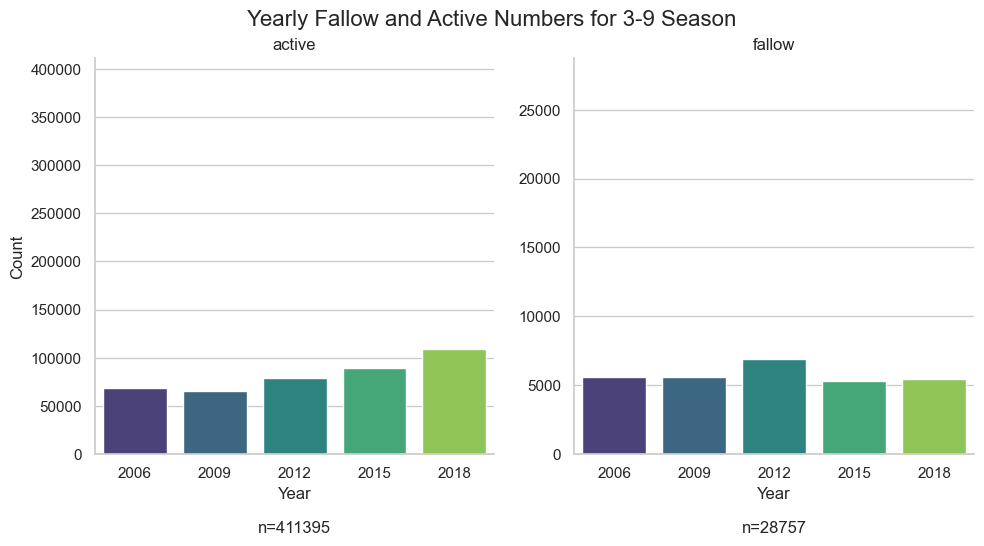

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Function to plot data for the single season
def plot_season_data(data):
    # Get the unique value from the "season" column
    season_name = data['season'].unique()[0]  # Assuming only one unique value for the season

    # Get the maximum count of observations for setting ylim
    max_count = data.groupby(['land_use_classes', 'year']).size().max()

    # Calculate the total number of rows per cover class
    total_per_class = data['land_use_classes'].value_counts()

    # Determine the number of unique land_use_classes
    num_land_use_classes = len(data['land_use_classes'].unique())

    # Calculate the number of columns based on the number of unique land_use_classes
    col_wrap = min(5, num_land_use_classes)

    # Create a facet grid with seaborn
    g = sns.FacetGrid(data, col="land_use_classes", col_wrap=col_wrap, height=5, sharey=False)

    # Map a bar plot for the number of observations per year, color by year
    g.map(sns.countplot, "year", order=sorted(data['year'].unique()), palette="viridis", legend=False)

    # Set titles and labels
    g.set_axis_labels("Year", "Count")
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(wspace=0.2)
    g.fig.suptitle(f"Yearly Fallow and Active Numbers for {season_name} Season", fontsize=16, y=1.02)  # Hier wurde die Überschrift angepasst

    # Set different ylim for the fallow subplot
    for ax, (cover_class, total_obs) in zip(g.axes.flat, total_per_class.items()):
        ax.set(ylim=(0, total_obs))
        
        # Annotate each subplot with the total number of observations per cover class
        ax.text(0.5, -0.2, f'n={total_obs}', transform=ax.transAxes, ha='center', va='baseline')

    # Show the plot
    plt.show()

# Plot für die einzelne Saison
plot_season_data(training_data)


#### welche Land-Covers kommen wie häufig vor bei Fallow und Active (lc1) ? 

c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\Ruben\.conda\envs\wilde\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without as

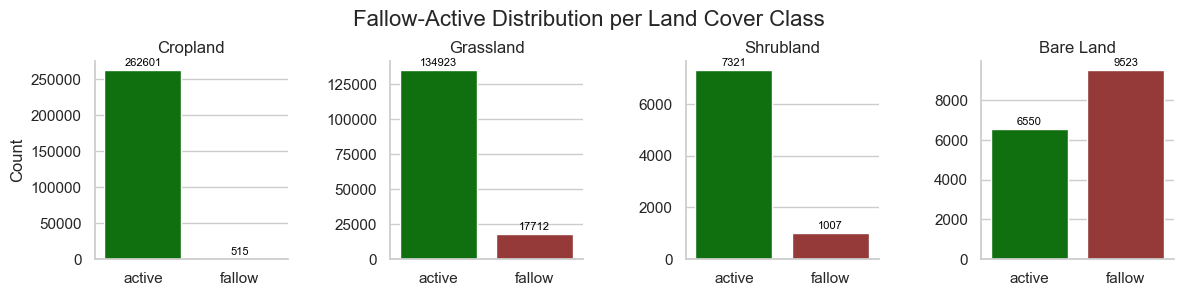

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Function to plot data for each season
def plot_landcover_occ(data):
    # Copy the data
    data_plot = data.copy()
    
    # Add a new column 'lc1_grouped' containing only the first letter of 'lc1'
    data_plot['lc1_grouped'] = data['lc1'].str[0]

    # Mapping 'lc1_grouped' to the desired legend
    legend_mapping = {'A': 'Artificial',
                      'B': 'Cropland',
                      'C': 'Woodland',
                      'D': 'Shrubland',
                      'E': 'Grassland',
                      'F': 'Bare Land',
                      'G': 'Water',
                      'H': 'Wetlands'}

    # Rename the categories in the 'lc1_grouped' column
    data_plot['lc1_grouped'] = data_plot['lc1_grouped'].map(legend_mapping)

    # Get the maximum count of observations for setting ylim
    max_count = data_plot.groupby(['lc1_grouped', 'land_use_classes']).size().max()

    # Calculate the total number of rows per cover class
    total_per_class = data_plot['lc1_grouped'].value_counts()

    # Create a facet grid with seaborn
    g = sns.FacetGrid(data_plot, col="lc1_grouped", col_wrap=4, height=3, sharey=False)

    # Map a bar plot for the number of observations per class, color by class
    g.map(sns.countplot, "land_use_classes", order=sorted(data_plot['land_use_classes'].unique()), palette={"active": "green", "fallow": "brown"}, legend=False)

    # Set titles and labels
    g.set_axis_labels('', "Count")
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(top=0.88)  # Adjust the top margin to make room for title

    # Annotate each subplot with the total number of observations per cover class
    for ax, (cover_class, total_obs) in zip(g.axes.flat, total_per_class.items()):
        #ax.text(0.5, 1.1, f'n={total_obs:.0f}', transform=ax.transAxes, ha='center', va='baseline')
        
        # Add counts on top of the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')

    # Show the plot with a dynamic title based on the content of the 'season' column
    plt.suptitle(f"Fallow-Active Distribution per Land Cover Class ", fontsize=16, y=1.05)  # Move the title up
    plt.show()

# Plot Data
plot_landcover_occ(training_data)


## ML Model Setup

### Setting up Caching of optimal model outputs

In [ ]:
# Define the paths for saving and loading the models
save_path = workPath + "/02_Training/ML_caching"

# Construct the model paths with information about season and sample size
rf_model_path = os.path.join(save_path, f"rf_regression_model_{desired_seasons}_{max_subset_size}.pkl")
ee_model_path = os.path.join(save_path, f"ee_regressor_model_{desired_seasons}_{max_subset_size}.pkl")


# To load the models if they exist:
if os.path.exists(rf_model_path):
    best_mod = joblib.load(rf_model_path)

if os.path.exists(ee_model_path):
    ee_regressor = joblib.load(ee_model_path)

### Cache cleaning

set flush_cash = True to clean cache

In [ ]:
flush_cash = False

# To flush (delete) the models if needed:
if flush_cash:
    if os.path.exists(rf_model_path):
        os.remove(rf_model_path)
    if os.path.exists(ee_model_path):
        os.remove(ee_model_path)
    if os.path.exists(svm_model_path):  
        os.remove(svm_model_path)
    if os.path.exists(ee_svm_model_path):
        os.remove(ee_svm_model_path)

### Prep training and test data

In dieser Version des Codes werden die Daten basierend auf den ausgewählten Jahreszeiten (seasons_to_use) gefiltert, und dann werden Trainings- und Testdaten nur aus den gefilterten Daten für diese Jahreszeiten erstellt.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Dictionary to store data for each class
class_data = {}

# Separate data based on classes
for class_label in np.unique(training_data['land_use_classes']):
    class_data[class_label] = training_data[training_data['land_use_classes'] == class_label]

# Initialize empty lists for train and test data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Percentage split for training and test data
train_percentage = 0.7  # 70% for training, adjust as needed

# Split each class into training and test sets for the selected seasons
for class_label, class_df in class_data.items():
    # Filter data for the selected seasons
    class_df_seasons = class_df[class_df['season'].isin(desired_seasons)]
    
    # Separate features and target
    X_class = class_df_seasons.drop(['DEM', 'id', 'lc1', 'lu1_label', 'point_id', 'point_id', 'year', 'land_use_classes', 'season'], axis=1)
    X_class = X_class.loc[:, ~X_class.columns.str.contains('bio')]
    y_class = class_df_seasons['land_use_classes']
    
    # Split class data into training and test sets
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
        X_class, y_class, test_size=1 - train_percentage, stratify=y_class, random_state=42
    )

    # Append the class data to the overall lists
    X_train_list.append(X_class_train)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class_train)
    y_test_list.append(y_class_test)

# Concatenate data from all classes to create final training and test sets
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Shuffle the data (optional)
shuffle_index_train = np.random.permutation(len(X_train))
shuffle_index_test = np.random.permutation(len(X_test))

X_train, y_train = X_train.iloc[shuffle_index_train], y_train.iloc[shuffle_index_train]
X_test, y_test = X_test.iloc[shuffle_index_test], y_test.iloc[shuffle_index_test]

# Check the shape of the training set
print("Shape of the training set:", X_train.shape)
# Check the shape of the test set
print("Shape of the test set:", X_test.shape)

# Label encoding for y_train and y_test
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Check the unique encoded values
encoded_classes = label_encoder.classes_
print("Encoded classes:", encoded_classes)


# Calculate the total number of samples in the training and test sets
total_samples_initial = len(training_data)
total_samples_train = len(y_train)
total_samples_test = len(y_test)

# Print class distribution in the initial training data as percent
print("Class distribution in initial training data:")
print((training_data['land_use_classes'].value_counts() / total_samples_initial) * 100)

# Print class distribution in training and test sets
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())
print((pd.Series(y_train).value_counts() / total_samples_train) * 100)

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())
print((pd.Series(y_test).value_counts() / total_samples_test) * 100)

# Calculate the total number of samples in the training and test sets
total_samples_initial = len(training_data)
total_samples_train = len(y_train)
total_samples_test = len(y_test)


## Model Training

## Random Forest

In [ ]:

# Create a classifier instance
RF = RandomForestClassifier(class_weight='balanced', random_state=42) # balanced
param_grid = {
    'max_depth':list(np.arange(10, 100, step=10)) + [None],
            'n_estimators':np.arange(10, 60, step=5),
            'max_features':randint(1,80),
            'criterion':['gini','entropy'],
            'min_samples_leaf':randint(5,80),
            'min_samples_split':np.arange(5, 80, step=2)
        }


RF_cv = RandomizedSearchCV(RF, 
                            param_distributions=param_grid, 
                            n_iter=5, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
                            n_jobs= -1, 
                            random_state=42, 
                            scoring='f1', # Wenn das Hauptziel darin besteht, das Ungleichgewicht der Klassen zu berücksichtigen, könnten Metriken wie Precision, Recall oder F1-Score relevanter sein als die Accuracy.
                            verbose=3)

# Fit the RandomizedSearchCV to your data
RF_cv.fit(X_train, y_train)

# Get the best parameters
best_params = RF_cv.best_params_

# Create the best model with the best parameters
best_mod = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)
best_mod.fit(X_train, y_train)

# Optionally, evaluate the best model on the test set
test_score = best_mod.score(X_test, y_test)

# Print the best parameters and test score
print("Best Parameters:", best_params)
print("Test Set Score:", test_score)

# Save the RandomForestrf model as a pickle
joblib.dump(best_mod, rf_model_path)

### Konvertierung in Earth-Engine Format und speicherung als Pickle

In [ ]:

# from geemap import ml
# # Get the feature names
# feature_names = X_class.columns.tolist()
# # Convert the model to a string representation
# best_mod_str = ml.rf_to_strings(best_mod, feature_names, output_mode="CLASSIFICATION", processes =8)
# # Convert the string representation back to a classifier
# ee_rf = ml.strings_to_classifier(best_mod_str)

# # Save the Earth Engine RandomForestrf model as a pickle
# joblib.dump(ee_rf, ee_model_path)

# ee_rf

# file_size = os.path.getsize(ee_model_path) / (1024 * 1024)
# print(f"The file size of {ee_model_path} \n is {file_size} MB.")


## Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#
best_mod = joblib.load(rf_model_path)

# Make predictions
y_train_pred = best_mod.predict(X_train)
y_test_pred = best_mod.predict(X_test)

# add weighting to prediciton of fallow 
y_pred_prob = best_mod.predict_proba(X_train)[:, 1]
#y_train_pred = (y_pred_prob > 0.3).astype(int)  # Adjust the threshold as needed

y_pred_prob = best_mod.predict_proba(X_test)[:, 1]
#y_test_pred = (y_pred_prob > 0.3).astype(int)  # Adjust the threshold as needed

# Get unique class labels
class_labels = sorted(set(y_train))

# Evaluate on training set
print("Training Set Metrics:")
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=class_labels)
print("\nAccuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Precision: {:.4f}".format(precision_score(y_train, y_train_pred, average='weighted')))
print("Recall: {:.4f}".format(recall_score(y_train, y_train_pred, average='weighted')))
print("F1 Score: {:.4f}".format(f1_score(y_train, y_train_pred, average='weighted')))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

class_labels = training_data["land_use_classes"].unique()
# Plotting the confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14},
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Normalize the confusion matrix to get values between 0 and 1 for each class
conf_matrix_train = conf_matrix_train.astype('float') / conf_matrix_train.sum(axis=1)[:, np.newaxis]
# Plotting the confusion matrix for testing set
# Get unique class labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt=".2f", cmap="viridis", cbar=False, annot_kws={"size": 14},
            xticklabels=class_labels, yticklabels=class_labels)

plt.title("Normalized Confusion Matrix - Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Evaluate on testing set
print("\nTesting Set Metrics:")
# Get unique class labels
class_labels = sorted(set(y_train))
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=class_labels)
class_labels = training_data["land_use_classes"].unique()
print("\nAccuracy: {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred, average='weighted')))
print("Recall: {:.4f}".format(recall_score(y_test, y_test_pred, average='weighted')))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred, average='weighted')))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Plotting the confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14},
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Normalize the confusion matrix to get values between 0 and 1 for each class
conf_matrix_test = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]
# Plotting the confusion matrix for testing set
# Get unique class labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2f", cmap="viridis", cbar=False, annot_kws={"size": 14},
            xticklabels=class_labels, yticklabels=class_labels)

plt.title("Normalized Confusion Matrix - Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Spatialize Prediction in GEE

In [ ]:
envelope, projSite = ProjSite_ToeeGeom(workPath + "/00_Shapefiles/wildE/europe_aggregated.gpkg")

LND_stm = Seasonal_STMs_C2(2021, projSite, 1, 12, reducer="all")

# Manuell die Bänder auswählen, die behalten werden sollen
bands_to_keep = ['B_mean', 'B_stdDev', 'B_p10', 'B_p25', 'B_p50', 'B_p75', 'B_p90', 'G_mean', 'G_stdDev', 'G_p10', 'G_p25', 'G_p50', 'G_p75', 'G_p90', 'R_mean', 'R_stdDev', 'R_p10', 'R_p25', 'R_p50', 'R_p75', 'R_p90', 'NIR_mean', 'NIR_stdDev', 'NIR_p10', 'NIR_p25', 'NIR_p50', 'NIR_p75', 'NIR_p90', 'SWIR1_mean', 'SWIR1_stdDev', 'SWIR1_p10', 'SWIR1_p25', 'SWIR1_p50', 'SWIR1_p75', 'SWIR1_p90', 'SWIR2_mean', 'SWIR2_stdDev', 'SWIR2_p10', 'SWIR2_p25', 'SWIR2_p50', 'SWIR2_p75', 'SWIR2_p90', 'NDVI_mean', 'NDVI_stdDev', 'NDVI_p10', 'NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_p90', 'SWIRratio_mean', 'SWIRratio_stdDev', 'SWIRratio_p10', 'SWIRratio_p25', 'SWIRratio_p50', 'SWIRratio_p75', 'SWIRratio_p90', 'NDWI_mean', 'NDWI_stdDev', 'NDWI_p10', 'NDWI_p25', 'NDWI_p50', 'NDWI_p75', 'NDWI_p90', 'EVI_mean', 'EVI_stdDev', 'EVI_p10', 'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_p90', 'MSAVI_mean', 'MSAVI_stdDev', 'MSAVI_p10', 'MSAVI_p25', 'MSAVI_p50', 'MSAVI_p75', 'MSAVI_p90', 'tcB_mean', 'tcB_stdDev', 'tcB_p10', 'tcB_p25', 'tcB_p50', 'tcB_p75', 'tcB_p90', 'tcG_mean', 'tcG_stdDev', 'tcG_p10', 'tcG_p25', 'tcG_p50', 'tcG_p75', 'tcG_p90', 'tcW_mean', 'tcW_stdDev', 'tcW_p10', 'tcW_p25', 'tcW_p50', 'tcW_p75', 'tcW_p90']

# Die ausgewählten Bänder aus dem Regressor auswählen
ee_regressor_modified = ee_regressor.select(bands_to_keep)

# Das Modell mit den geänderten Eingabedaten verwenden
rf_regression = LND_stm.classify(ee_regressor_modified)
rf_regression


rf_regression = LND_stm.classify(ee_regressor)
rf_regression

esaWC21 = ee.ImageCollection("ESA/WorldCover/v200").select(['Map']).toBands().clip(projSite)

# Define a color palette for ESA World Cover classes
esa_palette = [
    '#006400',  # Tree cover
    '#ffbb22',  # Shrubland
    '#ffff4c',  # Grassland
    '#f096ff',  # Cropland
    '#fa0000',  # Built-up
    '#b4b4b4',  # Bare / sparse vegetation
    '#f0f0f0',  # Snow and ice
    '#0064c8',  # Permanent water bodies
    '#0096a0',  # Herbaceous wetland
    '#00cf75',  # Mangroves
    '#fae6a0'   # Moss and lichen
]


esa_palette = [
    'darkgreen',  # Tree cover
    'green',  # Shrubland
    'lightgreen',  # Grassland
    'lightgreen',  # Cropland
    'red',  # Built-up
    'red',  # Bare / sparse vegetation
    'blue',  # Snow and ice
    'blue',  # Permanent water bodies
    'lightgreen',  # Herbaceous wetland
    'lightgreen',  # Mangroves
    'lightgreen'   # Moss and lichen
]

# Define visualization parameters for ESA World Cover
esa_vis_params = {
    'min': 10,
    'max': 100,
    'palette': esa_palette
}

In [ ]:
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, opacity=100):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True,
        opacity=opacity  # Set the opacity here
    ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set the center coordinates
center_coords = projSite.centroid().coordinates().getInfo()[::-1]

# Create a Folium map
map = folium.Map(location=center_coords, zoom_start=10)

# Add the satellite basemap
folium.TileLayer('https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google', name='Google Satellite', overlay=True).add_to(map)

# Define visualization parameters
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ["#EDF8E9", "#C7E9C0", "#A1D99B", "#74C476", "#41AB5D", "#238B45", "#005A32"]
}

# Set the opacity for the Earth Engine image layer (e.g., 0.7 for 70% opacity)
opacity = 0.7


# Add the ESA World Cover image to the map
map.add_ee_layer(esaWC21, esa_vis_params, name='ESA World Cover')
# Add the Earth Engine image to the map using folium_gee
map.add_ee_layer(rf_regression, vis_params, name=f'classification_{year}', opacity=100)
map.add_ee_layer(LND_stm.select(["NDVI_mean"]), {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, name='NDVI_mean')


# Add a layer control to the map
folium.LayerControl().add_to(map)


# Display the map
map